## 正则解析trace文件

In [1]:
import re
import json

In [7]:
class Trace:
    
    def __init__(self, path):
        self.path = path
        
    def __iter__(self):
        f = open(self.path)
        while True:
            line = f.readline()
            if line:
                yield line
            else:
                f.close()
                return

In [81]:
class Parse:
    
    def __init__(self, path):
        self.trace = Trace(path)
        self.patt_str = r'\{"a":.*?[(\])|(\})]\}'
        self.patt = re.compile(self.patt_str)
        self.res = []
        self.call = []
        self.nodes = {}
        self.trees = []
        self.loads()
        
    def loads(self):
        for line in self.trace:
            self.res.extend(
                [json.loads(tree) for tree in self.patt.findall(line)]
            )
            
    def parse_nodes(self):
        for node in self.res:
            if len(node['p']):
                for parent in node['p']:
                    if not parent in self.nodes.keys():
                        self.nodes[parent] = {
                            "name": "",
                            "time": None,
                            'childs': [node['a']]
                        }
                    else:
                        self.nodes[parent]['childs'].append(node['a'])
                    self.nodes[node['a']] = {
                        "name": node['d'],
                        "time": node['e'] - node['b'],
                        "childs": []
                    }
            else:
                self.call.append(node['a'])
                if node['a'] in self.nodes.keys():
                    self.nodes[node['a']]['name'] = node['d']
                    self.nodes[node['a']]['time'] =  node['e'] - node['b']
                else:
                    self.nodes[node['a']] = {
                        "name": node['d'],
                        "time": node['e'] - node['b'],
                        "childs": []
                    }
                    
    def build_tree(self):
        
        if not len(self.call):
            self.parse_nodes()
            
        def deepCall(root, callTree):
            if not len(self.nodes[root]['childs']):
                return
            for child in self.nodes[root]['childs']:
                callTree['childs'].append({
                    "hash": child,
                    "name": self.nodes[child]['name'],
                    "childs": []
                })
                deepCall(child, callTree['childs'][-1])

        for root in self.call:
            self.trees.append({
                "hash": root,
                "name": self.nodes[root]['name'],
                "childs": []
            })
            deepCall(root, self.trees[-1])

## 调用关系解析

In [82]:
import pandas as pd
import numpy as np
import seaborn as sb

In [83]:
bayes = Parse('htrace.out')
bayes.build_tree()
data = bayes.nodes.values()
func_info = {}

In [84]:
name, time, child = [],[],[]
def clean_nodes():
    for d in data:
        name.append(d['name'])
        time.append(d['time'])
        child.append(len(d['childs']))
clean_nodes()
func_info['name'] = name
func_info['time'] = time
func_info['child'] = child

## Bayes全采样信息

In [85]:
rootName = [bayes.nodes[h]['name'] for h in bayes.call]
se = pd.Series(rootName)
root_info = se.value_counts()

#### 根节点个数

In [86]:
root_info

DFSOutputStream#write           12191
getFileInfo                        32
FileSystem#createFileSystem        15
DFSOutputStream#close               8
Globber#glob                        7
DistributedFileSystem#create        7
setPermission                       5
DistributedFileSystem#mkdirs        3
setReplication                      2
DFSInputStream#byteArrayRead        2
DistributedFileSystem#delete        2
listPaths                           2
DistributedFileSystem#open          1
dtype: int64

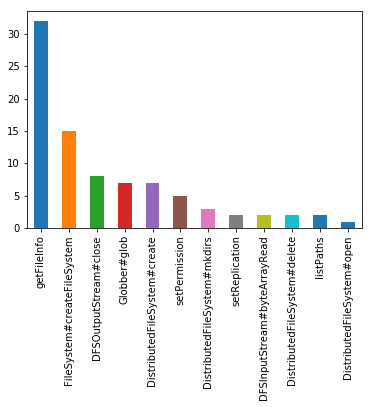

In [87]:
root_info.drop('DFSOutputStream#write').plot(kind='bar')

In [88]:
df = pd.DataFrame(func_info)

In [89]:
df['name'].value_counts()

DFSOutputStream#writeChunk[lengh=512]              109723
DFSOutputStream#write                               12198
DataStreamer#writeTo                                  884
dataStreamer                                          884
getFileInfo                                            36
ClientNamenodeProtocol#getFileInfo                     36
FileSystem#createFileSystem                            12
DFSOutputStream#close                                   8
DistributedFileSystem#create                            7
ClientNamenodeProtocol#complete                         7
ClientNamenodeProtocol#addBlock                         7
waitForAckedSeqno                                       7
newStreamForCreate                                      7
ClientNamenodeProtocol#create                           7
DFSOutputStream#flushInternal                           7
completeFile                                            7
setPermission                                           5
ClientNamenode

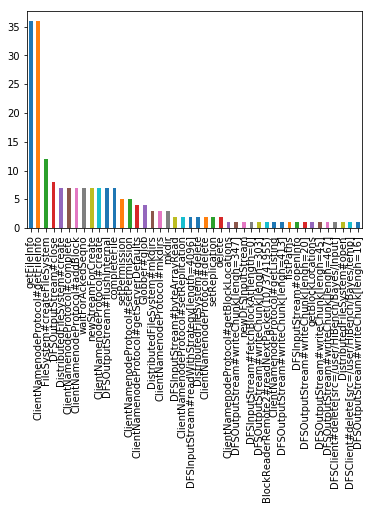

In [90]:
df['name'].value_counts().drop('DFSOutputStream#writeChunk[lengh=512]').drop('DFSOutputStream#write').drop('DataStreamer#writeTo').drop('dataStreamer').plot(kind='bar')

### 调用树关系

In [187]:
trees = [node for node in bayes.trees if len(node['childs'])]
hashtree = []
desc = {"d":"0(Globber#glob)"}

def compress(node, desc, deep, layer):
    layer = layer + "&" + str(deep)
    vis = []
    for index, child in enumerate(node['childs']):
        if child['name'] in vis:
            continue
        vis.append(child['name'])
        desc['d'] = desc['d'] + '->' + layer + "#" + str(index) + '(' + child['name'] + ')'
        compress(child, desc, deep+1, layer + "#" + str(index))

def hash_tree():
    for tree in trees:
        desc = {'d': '0'+'('+tree['name']+')'}
        compress(tree, desc, 1, '0')
        hashtree.append(desc['d'])
hash_tree()

In [191]:
se_tree = pd.Series(hashtree)
se_tree.value_counts()

0(DFSOutputStream#write)->0&1#0(DFSOutputStream#writeChunk[lengh=512])                                                                                             12191
0(getFileInfo)->0&1#0(ClientNamenodeProtocol#getFileInfo)                                                                                                             32
0(DistributedFileSystem#create)->0&1#0(newStreamForCreate)                                                                                                             7
0(Globber#glob)->0&1#0(getFileInfo)                                                                                                                                    7
0(setPermission)->0&1#0(ClientNamenodeProtocol#setPermission)                                                                                                          5
0(DFSOutputStream#close)->0&1#0(DFSOutputStream#write)->0&1#1(dataStreamer)->0&1#2(DFSOutputStream#flushInternal)->0&1#3(completeFile)                     

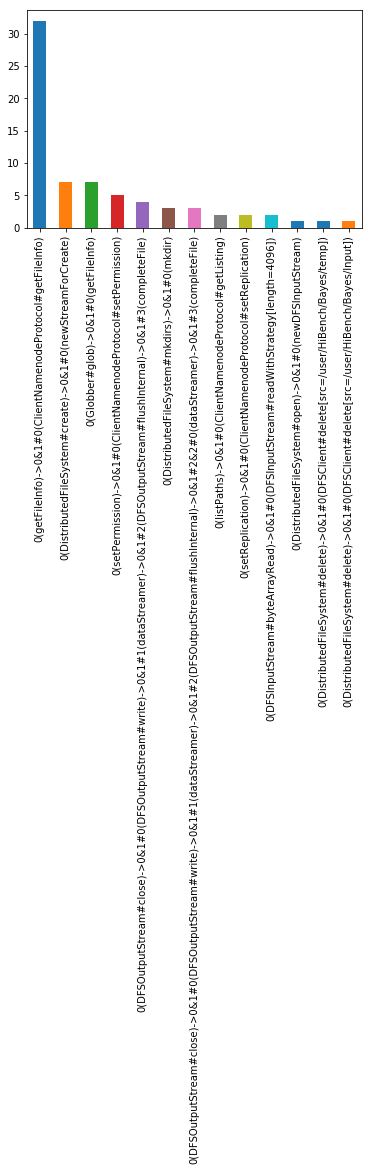

In [190]:
se_tree.value_counts().drop('0(DFSOutputStream#write)->0&1#0(DFSOutputStream#writeChunk[lengh=512])').plot(kind='bar')